## Importing Packages

In [45]:
import os
import sys
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import itertools
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



In [14]:
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Data Undersatding

In [15]:
df['category'].value_counts()

category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

In [16]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [17]:
df['target'] = np.where(df['label'] == 'CG', 1, 0)

### Destribution of categories by rating

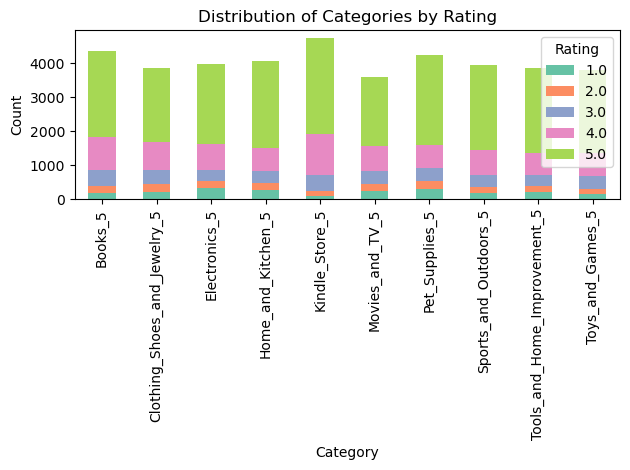

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

df_grouped = df.groupby(['category', 'rating']).size().unstack(fill_value=0)

ax = df_grouped.plot(kind='bar', stacked=True)

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories by Rating')
plt.xticks(rotation=90)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

- Some categories, such as "Books" and "Kindle Store," have a more substantial proportion of highly positive reviews (5.0), while others like "Electronics" and "Pet Supplies" have a relatively higher number of reviews with lower ratings (1.0, 2.0, and 3.0).

## EDA of Label column

<Figure size 1200x600 with 0 Axes>

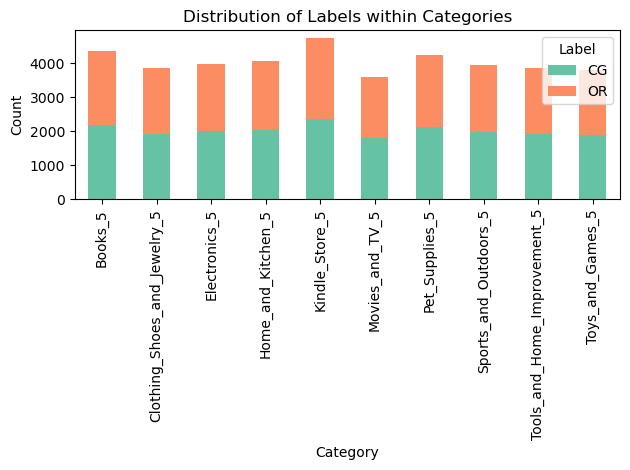

In [31]:
plt.figure(figsize=(12, 6))
label_category_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)
label_category_counts.plot(kind='bar', stacked=True)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Labels within Categories')
plt.xticks(rotation=90)
plt.legend(title='Label')
plt.tight_layout()

plt.show()

-  The table shows an equal distribution of the "CG" and "OR" labels within each category. 

In [37]:
df['word_count'] = df['text_'].apply(lambda x: len(x.split()))

In [38]:
label_word_counts = df.groupby('label')['word_count'].mean().sort_values(ascending=False)

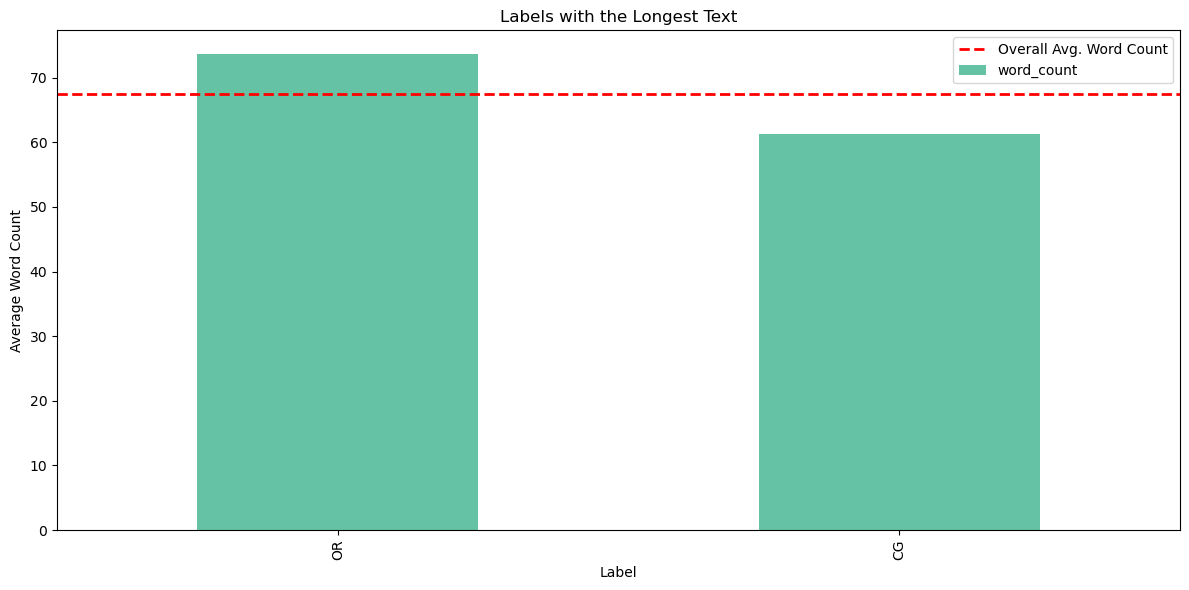

In [39]:
plt.figure(figsize=(12, 6))
label_word_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Average Word Count')
plt.title('Labels with the Longest Text')
plt.xticks(rotation=90)
plt.axhline(df['word_count'].mean(), color='red', linestyle='dashed', linewidth=2, label='Overall Avg. Word Count')
plt.legend()
plt.tight_layout()

plt.show()

- On average, reviews with the "OR" label have a higher word count compared to reviews labeled as "CG." The mean word count for "OR" reviews is approximately 73.64 words, while the mean word count for "CG" reviews is lower at around 61.29 words.

In [42]:
label_rating_counts = df.groupby(['label', 'rating']).size().unstack(fill_value=0)
label_rating_counts

rating,1.0,2.0,3.0,4.0,5.0
label,,,,,
CG,1063,962,1952,3920,12319
OR,1092,1005,1834,4045,12240


<Figure size 1200x600 with 0 Axes>

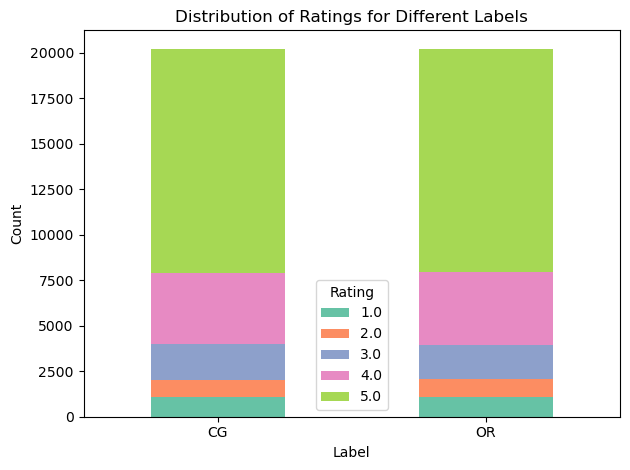

In [41]:
plt.figure(figsize=(12, 6))
label_rating_counts.plot(kind='bar', stacked=True)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Different Labels')
plt.xticks(rotation=0)  
plt.legend(title='Rating', labels=label_rating_counts.columns)
plt.tight_layout()
plt.show()

- Both "CG" and "OR" labels exhibit a relatively balanced distribution of ratings. While both labels have a similar distribution of ratings, the "CG" label appears to have slightly fewer reviews with 4.0 and 5.0 ratings compared to the "OR" label. Across both labels, positive ratings (4.0 and 5.0) significantly outnumber negative ratings (1.0 and 2.0).

In [44]:
label_category_counts = df.groupby(['label', 'category']).size().unstack(fill_value=0)
label_category_counts

category,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
label,,,,,,,,,,
CG,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897
OR,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897


<Figure size 1200x600 with 0 Axes>

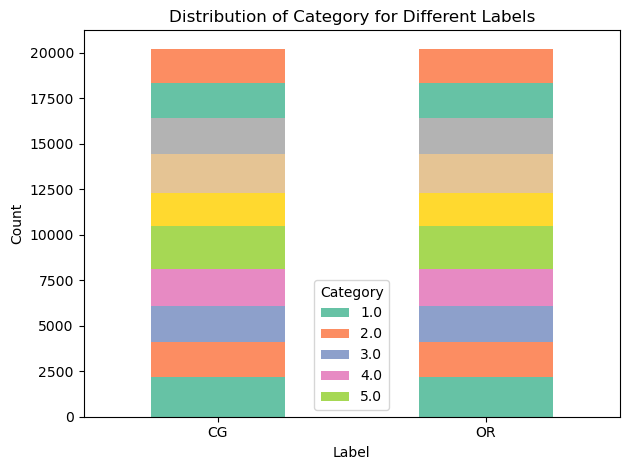

In [43]:
plt.figure(figsize=(12, 6))
label_category_counts.plot(kind='bar', stacked=True)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Category for Different Labels')
plt.xticks(rotation=0)  
plt.legend(title='Category', labels=label_rating_counts.columns)
plt.tight_layout()
plt.show()

-  The table reveals a consistent distribution of "CG" and "OR" labels across various product categories, with no apparent variation in label assignment within these categories.

### Word Cloud for Label column

In [46]:
df_cg = df[df['label'] == 'CG']  
df_or = df[df['label'] == 'OR']

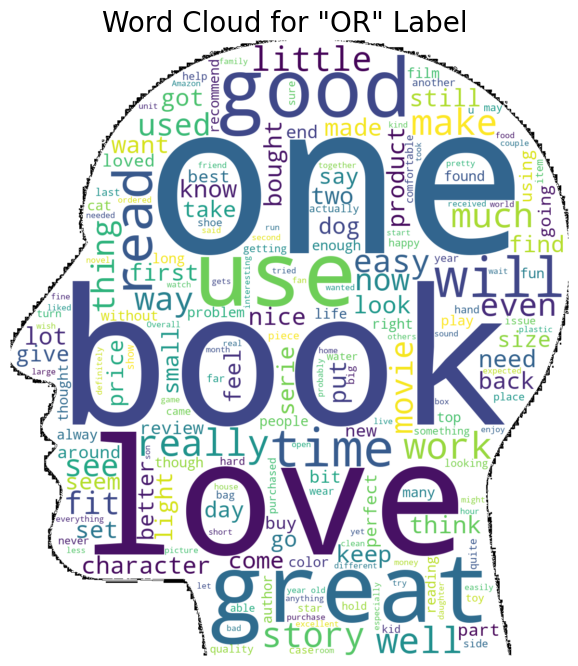

In [51]:
face_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/face_picture.jpeg'))
text_corpus = " ".join(df_or['text_'])

wordcloud = WordCloud(
    width=600,
    height=600,
    background_color='white',
    mask=face_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "OR" Label ', fontsize=20)
plt.show()

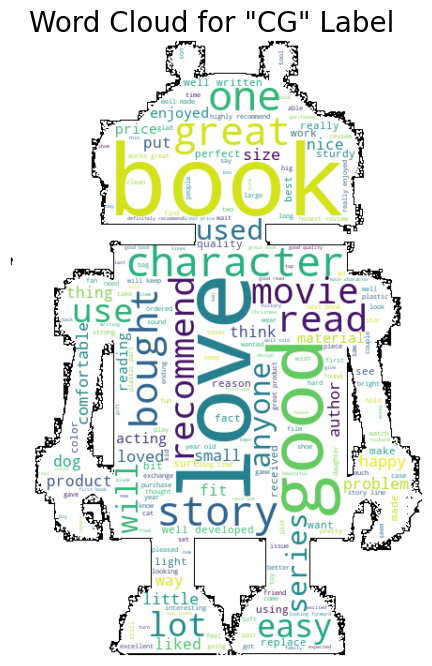

In [52]:
robot_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/SIlhouette.png'))
text_corpus_2 = " ".join(df_cg['text_'])

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    mask=robot_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus_2)


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "CG" Label ', fontsize=20)
plt.show()

## Text Preprocessing: Tokenization

In [19]:
#tokenizing the text data in the 'text_' column of df
def tokenizer(x):
    
    corpus = [word_tokenize(doc) for doc in x]

# getting common stop words in english that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    corpus_no_stopwords = []
    for words in corpus:
        docs = [x.lower() for x in words if ((x.isalpha()) & (x not in stop_words))]
        corpus_no_stopwords.append(docs)
    return corpus_no_stopwords

## Lemmantizer

In [20]:
def lemmatizer(corpus, as_string=True):
    lem = WordNetLemmatizer()
    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
    lemmatized_corpus = []
    for sentence in corpus:
        pos_tags = pos_tag(sentence)
        lemmatized_sentence = []
        for word, tag in pos_tags:
            pos = pos_tagger(tag)
            if pos is not None:
                lemmatized_word = lem.lemmatize(word, pos)
            else:
                lemmatized_word = lem.lemmatize(word)
            lemmatized_sentence.append(lemmatized_word)
        lemmatized_corpus.append(lemmatized_sentence)
    if as_string:
        lemmatized_corpus  = [' '.join(x) for x in lemmatized_corpus]
    return lemmatized_corpus
        

In [21]:
corpus_tokenized = tokenizer(df['text_'])

In [22]:
lemmatized_corpus = lemmatizer(corpus_tokenized)

## Pre vectorizing

In [23]:
joined_lemm_corpus = [' '.join(x) for x in lemmatized_corpus]
df['text_preproccesed'] = pd.Series(data=lemmatized_corpus)

In [24]:
vec = CountVectorizer(min_df = 0.05, max_df = 0.95)
X = vec.fit_transform(lemmatized_corpus)
countvec_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [ ]:
tfidf = TfidfVectorizer(min_df = 0.05, max_df = 0.95)
Y = tfidf.fit_transform(lemmatized_corpus)
tfidf_df = pd.DataFrame(Y.toarray(), columns=tfidf.get_feature_names())

In [ ]:
tfidf_df

In [ ]:
X

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(df['text_'],df['target'], test_size=0.3,random_state=42)

In [ ]:
X_train_preprocessed = lemmatizer(tokenizer(X_train))
X_test_preprocessed = lemmatizer(tokenizer(X_test))

In [ ]:
steps = [('countvec',CountVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200))]
pipe = Pipeline(steps)
pipe.fit(X_train_preprocessed, y_train)
y_pred = pipe.predict(X_test_preprocessed)

In [ ]:
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200))]
pipe = Pipeline(steps)
pipe.fit(X_train_preprocessed, y_train)
y_pred = pipe.predict(X_test_preprocessed)

In [ ]:
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('logreg',LogisticRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train_preprocessed, y_train)
y_pred = pipe.predict(X_test_preprocessed)

In [ ]:
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('logreg',LogisticRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train_preprocessed, y_train)
y_pred = pipe.predict(X_test_preprocessed)

In [ ]:
classification_report(y_test,y_pred,output_dict=True)